In [110]:


import pandas as pd

df_baseline = pd.read_pickle('output/df_metrics_baseline')

ignore_words = ['std', 'avg', 'kl', 'div', 'overlap']
output = lambda *x: os.path.join('output', *x)
def filter_metric_names(list_):
    return ['_'.join([x for x in name.split('_') if x not in ignore_words]) for name in list_]
df_by_config = pd.read_pickle(os.path.join('output', 'df_metrics_generation'))
df_by_config['config'] = df_by_config["in_len"].astype(str) + '_' + df_by_config["out_len"].astype(str)
df_by_config.drop(columns=['in_len','out_len','iteration'])
# print(df_by_config.head())
df_by_config = df_by_config.groupby(['model','checkpoint','config']).mean().reset_index()

# Get Subset DFs
col_metrics = df_by_config.columns
col_kl_divs  = [x for x in col_metrics if x.endswith('kl_div')]
col_overlaps = [x for x in col_metrics if x.endswith('overlap')]

# Calculate KL Divs mean and std per model config
loc_kldivs = df_by_config[['model'] + col_kl_divs].loc[: , "bar_pitch_class_histogram_kl_div":"note_length_hist_kl_div"]
df_by_config['kl_mean'] = loc_kldivs.mean(axis=1)
df_by_config['kl_std'] = loc_kldivs.std(axis=1)
loc_overlaps = df_by_config[['model'] + col_overlaps].loc[: , "bar_pitch_class_histogram_overlap":"note_length_hist_overlap"]
df_by_config['overlap_mean'] = loc_overlaps.mean(axis=1)
df_by_config['overlap_std'] = loc_overlaps.std(axis=1)
df_mean_metrics = df_by_config.copy()
maxes = df_mean_metrics.loc[df_mean_metrics.groupby(['model','checkpoint'])['overlap_mean'].idxmax()]
maxes['seconds_per_bar'] = maxes['time'] / maxes['out_len'] / 10
cols = ['model', 'checkpoint', 'config']
maxes['model_config'] = maxes[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
maxes.to_pickle(output('df_best_configs'))
maxes = maxes.drop(columns=['model','checkpoint','config','in_len','iteration'])
maxes.set_index('model_config', drop=True)

subplots = (
    [ ('_overlap', 'Best Model Configuration: Metric Overlap against Dataset')
    , ('_kl_div', 'Best Model Configuration: Metric KL-Divergence against Dataset')
    ]
)

# Convert DataFrame to Long-Form, splitting by metric type (Overlap / KL-Divergence)
metrics = [metric for metric in maxes.columns for (suffix,_) in subplots if metric.endswith(suffix)]
maxes = maxes[['model_config'] + metrics]
maxes = maxes.melt(id_vars=["model_config"], var_name="metric", value_name="score").dropna()
maxes['metric_type'] = maxes['metric'].astype(str).str.contains(subplots[0][0]).apply(lambda x: 'Overlap' if x == True else 'KL-Divergence')
maxes['metric'] = filter_metric_names(maxes['metric'])
# Prepare "best configs" dataframe to receive baselines
df_comp = maxes.copy()
df_comp['config'] = df_comp['model_config'].apply(lambda config: config.split(':')[-1])
df_comp['subject'] = df_comp['model_config'].apply(lambda config: ':'.join(config.split(':')[:-1]))
df_comp = df_comp.drop(columns=['model_config'])

df_baseline['subject'] = df_baseline['model'] + ':' + df_baseline['checkpoint']
df_baseline = df_baseline.drop(columns=['model','checkpoint','dataset'])

df_baseline = df_baseline.melt(id_vars=["subject"], var_name="metric", value_name="score").dropna()
df_baseline['metric_type'] = df_baseline['metric'].astype(str).str.contains('_overlap').apply(lambda x: 'Overlap' if x == True else 'KL-Divergence')
df_baseline['metric'] = filter_metric_names(df_baseline['metric'])


df_comp_bk = df_comp.copy()
df_comp = df_comp.merge(df_baseline, how='inner', on=['subject', 'metric', 'metric_type'], suffixes=("_gen", "_baseline"))

# Split baseline/generated sample scores
df_comp = df_comp.melt(id_vars=["subject", "metric", "metric_type", "config"], var_name="source", value_name="score").dropna()

# Split metric scores by type (KL-Divergence / Overlap)
df_comp = df_comp.pivot_table(index=['subject','metric', 'source', 'config'], columns='metric_type')
df_comp.columns = df_comp.columns.droplevel().rename(None)
df_comp['KL-Divergence'] = df_comp['KL-Divergence'].astype(float)
df_comp['Overlap'] = df_comp['Overlap'].astype(float)
df_comp = df_comp.reset_index()

# Rename sample sources
for oldname, newname in [('score_baseline', 'Baseline'), ('score_gen', "Generated Samples")]:
    df_comp.loc[df_comp['source'] == oldname, 'source'] = newname




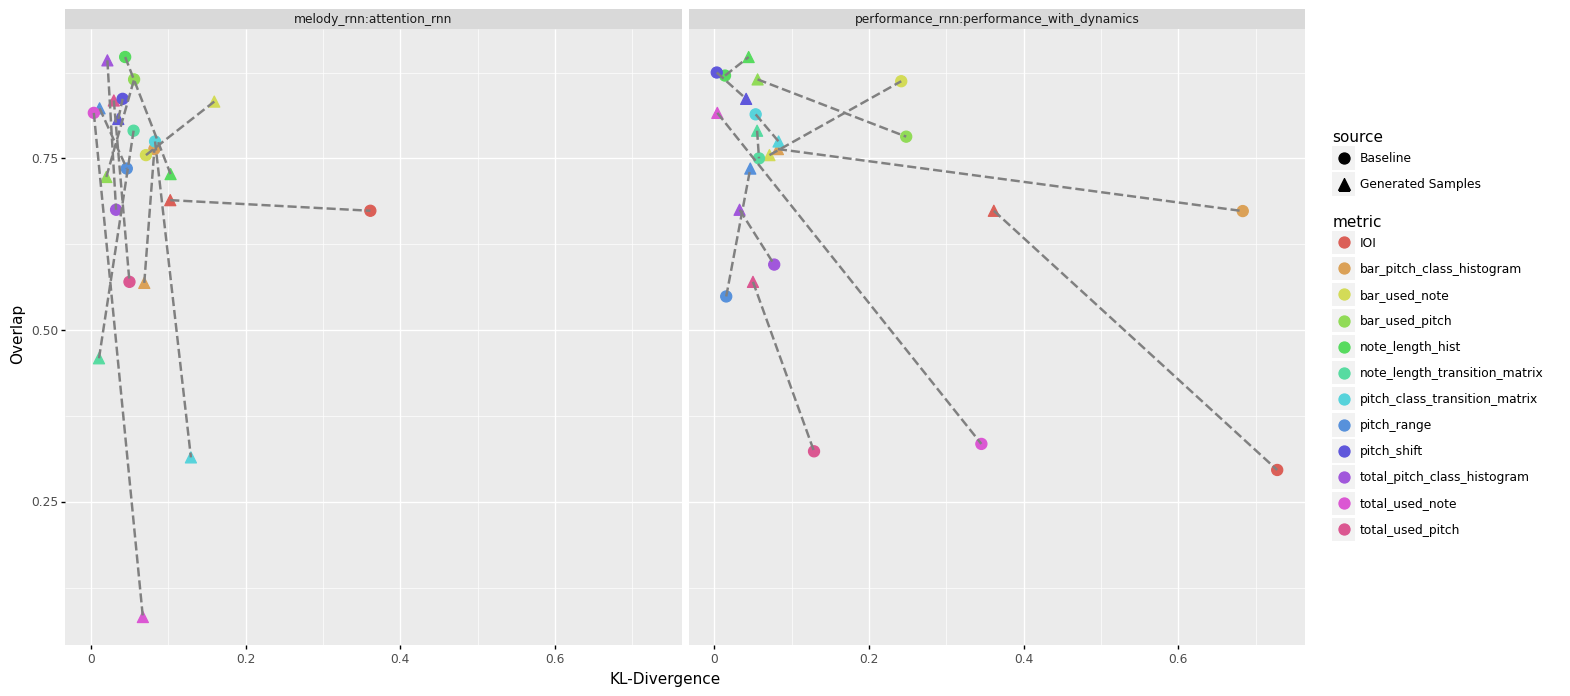

<ggplot: (8728838546397)>

In [118]:

from plotnine import ggplot, geom_point, aes,geom_line, theme, facet_wrap
from math import ceil

# df_comp = df_comp[['subject', 'metric', 'source', 'KL-Divergence', 'Overlap']]
subjects = len(df_comp['subject'].unique())
(
    ggplot(df_comp)
    + facet_wrap(['subject'])
    + geom_point(aes(shape='source', color='metric', x='KL-Divergence', y='Overlap'), size=4)
    + geom_line(aes(group='metric', x='KL-Divergence', y='Overlap'), color='grey', linetype='dashed', size=1)
    + theme(figure_size=(16, 8 * ceil(subjects/2)))
)